The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3
!pip install -U mxnet-cu112==1.9.1


# Matrix Factorization

Matrix Factorization :cite:`Koren.Bell.Volinsky.2009` is a well-established algorithm in the recommender systems literature. The first version of matrix factorization model is proposed by Simon Funk in a famous [blog
post](https://sifter.org/%7Esimon/journal/20061211.html) in which he described the idea of factorizing the interaction matrix. It then became widely known due to the Netflix contest which was held in 2006. At that time, Netflix, a media-streaming and video-rental company, announced a contest to improve its recommender system performance. The best team that can improve on the Netflix baseline, i.e., Cinematch), by 10 percent would win a one million USD prize.  As such, this contest attracted
a lot of attention to the field of recommender system research. Subsequently, the grand prize was won by the BellKor's Pragmatic Chaos team, a combined team of BellKor, Pragmatic Theory, and BigChaos (you do not need to worry about these algorithms now). Although the final score was the result of an ensemble solution (i.e., a combination of many algorithms), the matrix factorization algorithm played a critical role in the final blend. The technical report of the Netflix Grand Prize solution :cite:`Toscher.Jahrer.Bell.2009` provides a detailed introduction to the adopted model. In this section, we will dive into the details of the matrix factorization model and its implementation.


## The Matrix Factorization Model

Matrix factorization is a class of collaborative filtering models. Specifically, the model factorizes the user-item interaction matrix (e.g., rating matrix) into the product of two lower-rank matrices, capturing the low-rank structure of the user-item interactions.

Let $\mathbf{R} \in \mathbb{R}^{m \times n}$ denote the interaction matrix with $m$ users and $n$ items, and the values of $\mathbf{R}$ represent explicit ratings. The user-item interaction will be factorized into a user latent matrix $\mathbf{P} \in \mathbb{R}^{m \times k}$ and an item latent matrix $\mathbf{Q} \in \mathbb{R}^{n \times k}$, where $k \ll m, n$, is the latent factor size. Let $\mathbf{p}_u$ denote the $u^\textrm{th}$ row of $\mathbf{P}$ and $\mathbf{q}_i$ denote the $i^\textrm{th}$ row of $\mathbf{Q}$.  For a given item $i$, the elements of $\mathbf{q}_i$ measure the extent to which the item possesses those characteristics such as the genres and languages of a movie. For a given user $u$, the elements of $\mathbf{p}_u$ measure the extent of interest the user has in items' corresponding characteristics. These latent factors might measure obvious dimensions as mentioned in those examples or are completely uninterpretable. The predicted ratings can be estimated by

$$\hat{\mathbf{R}} = \mathbf{PQ}^\top$$

where $\hat{\mathbf{R}}\in \mathbb{R}^{m \times n}$ is the predicted rating matrix which has the same shape as $\mathbf{R}$. One major problem of this prediction rule is that users/items biases can not be modeled. For example, some users tend to give higher ratings or some items always get lower ratings due to poorer quality. These biases are commonplace in real-world applications. To capture these biases, user specific and item specific bias terms are introduced. Specifically, the predicted rating user $u$ gives to item $i$ is calculated by

$$
\hat{\mathbf{R}}_{ui} = \mathbf{p}_u\mathbf{q}^\top_i + b_u + b_i
$$

Then, we train the matrix factorization model by minimizing the mean squared error between predicted rating scores and real rating scores.  The objective function is defined as follows:

$$
\underset{\mathbf{P}, \mathbf{Q}, b}{\mathrm{argmin}} \sum_{(u, i) \in \mathcal{K}} \| \mathbf{R}_{ui} -
\hat{\mathbf{R}}_{ui} \|^2 + \lambda (\| \mathbf{P} \|^2_F + \| \mathbf{Q}
\|^2_F + b_u^2 + b_i^2 )
$$

where $\lambda$ denotes the regularization rate. The regularizing term $\lambda (\| \mathbf{P} \|^2_F + \| \mathbf{Q}
\|^2_F + b_u^2 + b_i^2 )$ is used to avoid over-fitting by penalizing the magnitude of the parameters. The $(u, i)$ pairs for which $\mathbf{R}_{ui}$ is known are stored in the set
$\mathcal{K}=\{(u, i) \mid \mathbf{R}_{ui} \textrm{ is known}\}$. The model parameters can be learned with an optimization algorithm, such as Stochastic Gradient Descent and Adam.

An intuitive illustration of the matrix factorization model is shown below:

![Illustration of matrix factorization model](../img/rec-mf.svg)

In the rest of this section, we will explain the implementation of matrix factorization and train the model on the MovieLens dataset.


In [1]:
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Model Implementation

First, we implement the matrix factorization model described above. The user and item latent factors can be created with the `nn.Embedding`. The `input_dim` is the number of items/users and the `output_dim` is the dimension of the latent factors $k$.  We can also use `nn.Embedding` to create the user/item biases by setting the `output_dim` to one. In the `forward` function, user and item ids are used to look up the embeddings.


In [2]:
class MF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(input_dim=num_users, output_dim=num_factors)
        self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i)
        return outputs.flatten()

## Evaluation Measures

We then implement the RMSE (root-mean-square error) measure, which is commonly used to measure the differences between rating scores predicted by the model and the actually observed ratings (ground truth) :cite:`Gunawardana.Shani.2015`. RMSE is defined as:

$$
\textrm{RMSE} = \sqrt{\frac{1}{|\mathcal{T}|}\sum_{(u, i) \in \mathcal{T}}(\mathbf{R}_{ui} -\hat{\mathbf{R}}_{ui})^2}
$$

where $\mathcal{T}$ is the set consisting of pairs of users and items that you want to evaluate on. $|\mathcal{T}|$ is the size of this set. We can use the RMSE function provided by `mx.metric`.


In [3]:
def evaluator(net, test_iter, devices):
    rmse = mx.metric.RMSE()  # Get the RMSE
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        u = gluon.utils.split_and_load(users, devices, even_split=False)
        i = gluon.utils.split_and_load(items, devices, even_split=False)
        r_ui = gluon.utils.split_and_load(ratings, devices, even_split=False)
        r_hat = [net(u, i) for u, i in zip(u, i)]
        rmse.update(labels=r_ui, preds=r_hat)
        rmse_list.append(rmse.get()[1])
    return float(np.mean(np.array(rmse_list)))

## Training and Evaluating the Model


In the training function, we adopt the $\ell_2$ loss with weight decay. The weight decay mechanism has the same effect as the $\ell_2$ regularization.


In [4]:
#@save
def train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices=d2l.try_all_gpus(), evaluator=None,
                        **kwargs):
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2],
                            legend=['train loss', 'test RMSE'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            timer.start()
            input_data = []
            values = values if isinstance(values, list) else [values]
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            train_feat = input_data[:-1] if len(values) > 1 else input_data
            train_label = input_data[-1]
            with autograd.record():
                preds = [net(*t) for t in zip(*train_feat)]
                ls = [loss(p, s) for p, s in zip(preds, train_label)]
            [l.backward() for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        if len(kwargs) > 0:  # It will be used in section AutoRec
            test_rmse = evaluator(net, test_iter, kwargs['inter_mat'],
                                  devices)
        else:
            test_rmse = evaluator(net, test_iter, devices)
        train_l = l / (i + 1)
        animator.add(epoch + 1, (train_l, test_rmse))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test RMSE {test_rmse:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

Finally, let's put all things together and train the model. Here, we set the latent factor dimension to 30.


train loss 0.065, test RMSE 1.066
56722.8 examples/sec on [gpu(0), gpu(1)]


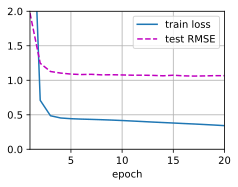

In [5]:
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = d2l.split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)
net = MF(30, num_users, num_items)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 20, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, evaluator)

Below, we use the trained model to predict the rating that a user (ID 20) might give to an item (ID 30).


In [6]:
scores = net(np.array([20], dtype='int', ctx=devices[0]),
             np.array([30], dtype='int', ctx=devices[0]))
scores

array([3.1718655], ctx=gpu(0))

## Summary

* The matrix factorization model is widely used in recommender systems.  It can be used to predict ratings that a user might give to an item.
* We can implement and train matrix factorization for recommender systems.


## Exercises

* Vary the size of latent factors. How does the size of latent factors influence the model performance?
* Try different optimizers, learning rates, and weight decay rates.
* Check the predicted rating scores of other users for a specific movie.


[Discussions](https://discuss.d2l.ai/t/400)
